<a href="https://colab.research.google.com/github/R1chardJr/CNN-Cats-VS-Dogs/blob/main/CNNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas necessárias

In [ ]:
# Para manipulação de dados e sistema
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
import random

# Para trabalhar com os modelos
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Para visualização e avaliação
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML

# Baixando o dataset e o organizando

Baixando o dataset de um link público

In [ ]:
!wget -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip -O cats_and_dogs.zip

Descompactando o arquivo principal

In [ ]:
with zipfile.ZipFile('cats_and_dogs.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_data')

Removendo arquivos Thumbs.db que podem estar na pasta PetImages para evitar futuros erros

In [ ]:
if os.path.exists('temp_data/PetImages/Cat/Thumbs.db'):
    os.remove('temp_data/PetImages/Cat/Thumbs.db')
if os.path.exists('temp_data/PetImages/Dog/Thumbs.db'):
    os.remove('temp_data/PetImages/Dog/Thumbs.db')

Criando as pastas de treino e validação e movendo os arquivos

In [ ]:
base_dir = 'dataset-caes-e-gatos'
if os.path.exists(base_dir):
  shutil.rmtree(base_dir) # Remove a pasta se já existir para um começo limpo

# Recria as pastas necessárias
train_dir = os.path.join(base_dir, 'treino')
validation_dir = os.path.join(base_dir, 'validacao')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

train_cats_dir = os.path.join(train_dir, 'gatos')
train_dogs_dir = os.path.join(train_dir, 'caes')
validation_cats_dir = os.path.join(validation_dir, 'gatos')
validation_dogs_dir = os.path.join(validation_dir, 'caes')
os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)
os.makedirs(validation_cats_dir, exist_ok=True)
os.makedirs(validation_dogs_dir, exist_ok=True)

Função responsável por separar e organizar os arquivos nas pastas, ignorando arquivos corrompidos/vazios

In [ ]:
def split_and_move_data(source_dir, train_dest, val_dest, split_size=0.8):
    files = []
    for filename in os.listdir(source_dir):
        file = os.path.join(source_dir, filename)
        if os.path.getsize(file) > 0: # Ignora arquivos corrompidos/vazios
            files.append(filename)

    train_size = int(len(files) * split_size)

    train_files = files[:train_size]
    val_files = files[train_size:]

    for filename in train_files:
        shutil.copyfile(os.path.join(source_dir, filename), os.path.join(train_dest, filename))
    for filename in val_files:
        shutil.copyfile(os.path.join(source_dir, filename), os.path.join(val_dest, filename))


Movendo os dados e estruturando o dataset

In [ ]:
split_and_move_data('temp_data/PetImages/Cat', train_cats_dir, validation_cats_dir)
split_and_move_data('temp_data/PetImages/Dog', train_dogs_dir, validation_dogs_dir)

# Limpeza
shutil.rmtree('temp_data')
os.remove('cats_and_dogs.zip')

print(f"Imagens de gatos para treino: {len(os.listdir(train_cats_dir))}")
print(f"Imagens de cães para treino: {len(os.listdir(train_dogs_dir))}")
print(f"Imagens de gatos para validação: {len(os.listdir(validation_cats_dir))}")
print(f"Imagens de cães para validação: {len(os.listdir(validation_dogs_dir))}")

Imagens de gatos para treino: 9999
Imagens de cães para treino: 9999
Imagens de gatos para validação: 2500
Imagens de cães para validação: 2500


E como podemos ver, temos um dataset balanceado

Exibindo algumas imagens do dataset para termos conhecimento de como ele é

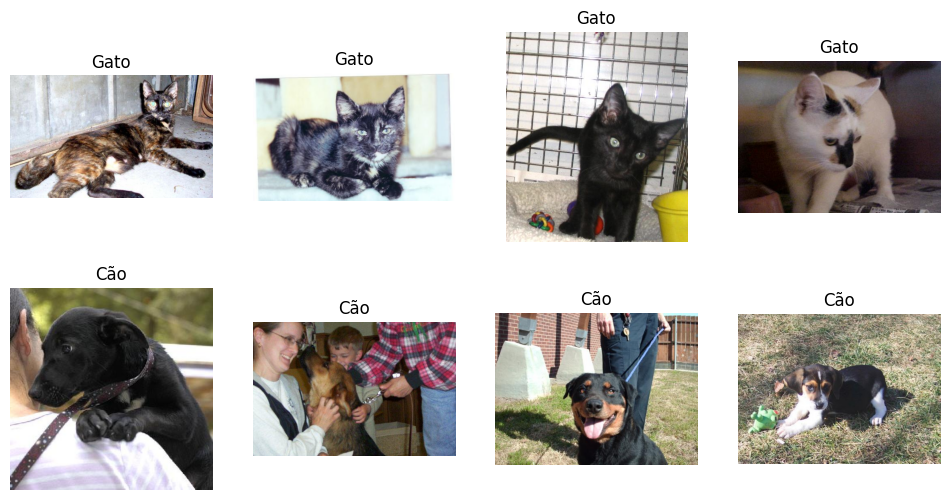

In [ ]:
gatos_treino_dir = 'dataset-caes-e-gatos/treino/gatos'
caes_treino_dir = 'dataset-caes-e-gatos/treino/caes'

gatos_files = [os.path.join(gatos_treino_dir, f) for f in os.listdir(gatos_treino_dir)]
caes_files = [os.path.join(caes_treino_dir, f) for f in os.listdir(caes_treino_dir)]

imagens_para_plotar = random.sample(gatos_files, 4) + random.sample(caes_files, 4)

plt.figure(figsize=(12, 6))
for i, img_path in enumerate(imagens_para_plotar):
    plt.subplot(2, 4, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)

    parent_folder = os.path.basename(os.path.dirname(img_path))

    if parent_folder == 'gatos':
        plt.title('Gato')
    elif parent_folder == 'caes':
        plt.title('Cão')

    plt.axis('off')

plt.show()

# Limpeza e preparação dos dados

Limpeza de dados corrompidos, para garantir que o modelo não tente ler um arquivo inválido mais tarde, o que causaria um erro e pararia o treinamento

In [ ]:
train_dir = 'dataset-caes-e-gatos/treino'
validation_dir = 'dataset-caes-e-gatos/validacao'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

def get_paths_and_labels(base_dir):
    all_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
    name_to_label = {name: i for i, name in enumerate(class_names)}

    for class_name, label in name_to_label.items():
        class_dir = os.path.join(base_dir, class_name)
        paths = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]
        all_paths.extend(paths)
        all_labels.extend([label] * len(paths))
    return all_paths, all_labels, class_names

train_paths, train_labels, class_names = get_paths_and_labels(train_dir)
val_paths, val_labels, _ = get_paths_and_labels(validation_dir)


Redimensionamento das imagens

In [ ]:
def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False, dtype=tf.float32)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
    return img

Fazendo a verificação individual dos arquivos com o TensorFlow a fim de procurar futuras imagens problemáticas

In [ ]:
def verify_and_filter_files(paths, labels):
    valid_paths = []
    valid_labels = []
    corrupted_archives = 0
    for i, (path, label) in enumerate(zip(paths, labels)):
        try:
            # Tenta processar 1 arquivo, se falhar econtramos um arquivo corrompido, o except é acionado.
            _ = process_path(path)
            # Se não falhar, o arquivo é bom e adicionamos a lista de válidos.
            valid_paths.append(path)
            valid_labels.append(label)
        except tf.errors.InvalidArgumentError as e:
            # Arquivos com erro
            corrupted_archives += 1
    print(f"Quantidade de arquivos corrompidos retirados: {corrupted_archives}")
    return valid_paths, valid_labels

# Faz a verificação
train_paths, train_labels = verify_and_filter_files(train_paths, train_labels)
val_paths, val_labels = verify_and_filter_files(val_paths, val_labels)

Quantidade de arquivos corrompidos retirados: 6
Quantidade de arquivos corrompidos retirados: 1


Como a quantidade de imagens que foram retiradas é insignificante comparando com o tamanho do dataset, ele ainda se mantem balanceado

Pipeline Final com os arquivos limpos para poder alimentar os modelos da forma mais eficiente

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

def final_process_path(file_path, label):
    return process_path(file_path), tf.cast(label, tf.float32)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = (
    train_ds
    .shuffle(buffer_size=len(train_paths))
    .map(final_process_path, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)
validation_dataset = (
    val_ds
    .map(final_process_path, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)


# Rede MLP

Iniciamos a abordagem do problema com uma rede MLP para ter uma base de comparação no futuro com as CNNS

Modelando uma rede MLP para fazer a tarefa de classificação das imagens

In [ ]:
model_mlp = Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Rescaling(1./255), s
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,299,905 (24.03 MB)

 Trainable params: 6,299,905 (24.03 MB)

 Non-trainable params: 0 (0.00 B)

Treinando a rede MLP

In [ ]:
history_mlp = model_mlp.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)


Treinando a MLP (baseline)...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.5562 - loss: 0.6832 - val_accuracy: 0.6093 - val_loss: 0.6583
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6124 - loss: 0.6560 - val_accuracy: 0.6139 - val_loss: 0.6523
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6265 - loss: 0.6432 - val_accuracy: 0.6227 - val_loss: 0.6468
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6366 - loss: 0.6339 - val_accuracy: 0.6273 - val_loss: 0.6414
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6447 - loss: 0.6238 - val_accuracy: 0.6311 - val_loss: 0.6455
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6537 - loss: 0.6154 - val_accuracy: 0.6357 - val_loss: 0.6476
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6612 - loss: 0.6073 - val_accuracy: 0.6339 - val_loss: 0.6488
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6671 

Guardando os resultados para comparar futuramente

In [ ]:
mlp_accuracy = history_mlp.history['val_accuracy'][-1]
mlp_params = model_mlp.count_params()

# CNNS

Definindo o parametro comum

In [ ]:
IMG_SHAPE = (128, 128, 3)

Iniciando a modelagem das redes CNNS

In [ ]:
model_CNN1 = Sequential([
        layers.Input(shape=IMG_SHAPE),
        layers.Rescaling(1./255),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

Observando a estrutura da primeira rede CNN

In [ ]:
model_CNN1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,777 (1.11 MB)

 Trainable params: 291,329 (1.11 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model_CNN1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_CNN1 = model_CNN1.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.6122 - loss: 0.6528 - val_accuracy: 0.5387 - val_loss: 0.6699
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.6742 - loss: 0.5973 - val_accuracy: 0.5695 - val_loss: 0.9416
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7071 - loss: 0.5627 - val_accuracy: 0.5987 - val_loss: 0.7908
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7326 - loss: 0.5339 - val_accuracy: 0.6767 - val_loss: 0.6481
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7502 - loss: 0.5078 - val_accuracy: 0.7407 - val_loss: 0.5095
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7676 - loss: 0.4821 - val_accuracy: 0.7658 - val_loss: 0.4770
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7822 - loss: 0.4588 - val_accuracy: 0.7219 - val_loss: 0.5855
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.7974 - loss: 0.4373 - 

Na primeira rede CNN já foi possível ver a melhora com relação a rede MLP

Agora,com a mesma rede CNN mas alterando o tamnho do kernel de 3x3 para 5x5 faremos o mesmo já feito na rede anterior

In [ ]:
model_CNN2 = Sequential([
        layers.Input(shape=IMG_SHAPE),
        layers.Rescaling(1./255),

        layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

In [ ]:
model_CNN2.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,153 (1.74 MB)

 Trainable params: 456,705 (1.74 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model_CNN2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_CNN2 = model_CNN2.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.6161 - loss: 0.6484 - val_accuracy: 0.6223 - val_loss: 0.6582
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.6858 - loss: 0.5839 - val_accuracy: 0.6581 - val_loss: 0.6264
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7456 - loss: 0.5130 - val_accuracy: 0.7437 - val_loss: 0.5301
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.7870 - loss: 0.4519 - val_accuracy: 0.7850 - val_loss: 0.4693
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.8137 - loss: 0.4051 - val_accuracy: 0.7894 - val_loss: 0.4546
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.8374 - loss: 0.3660 - val_accuracy: 0.8310 - val_loss: 0.3863
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8549 - loss: 0.3324 - val_accuracy: 0.8300 - val_loss: 0.3910
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8699 - loss: 0.3035 - 

Com a mudança do kernel houve uma melhora no desempenho da rede para este problema

Agora, nesse próximo teste voltamos para o kernel 3x3 e adicionamos mais uma camada convolucional a rede

In [ ]:
model_CNN3 = Sequential([
        layers.Input(shape=IMG_SHAPE),
        layers.Rescaling(1./255),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

In [ ]:
model_CNN3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,505 (2.49 MB)

 Trainable params: 652,545 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model_CNN3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history_CNN = model_CNN3.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.6019 - loss: 0.6755 - val_accuracy: 0.5079 - val_loss: 0.7353
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.6935 - loss: 0.5811 - val_accuracy: 0.5031 - val_loss: 2.5122
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7409 - loss: 0.5228 - val_accuracy: 0.5865 - val_loss: 0.7007
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7793 - loss: 0.4627 - val_accuracy: 0.6579 - val_loss: 0.7410
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.8180 - loss: 0.4045 - val_accuracy: 0.7483 - val_loss: 0.5972
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8471 - loss: 0.3536 - val_accuracy: 0.7572 - val_loss: 0.4854
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8653 - loss: 0.3060 - val_accuracy: 0.6669 - val_loss: 0.6539
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.8896 - loss: 0.2604 - 

E por último voltaremos a um kernel 5x5 no modelo

In [ ]:
model_CNN4 = Sequential([
        layers.Input(shape=IMG_SHAPE),
        layers.Rescaling(1./255),

        layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

In [ ]:
model_CNN4.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 16, 16, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,343,169 (5.12 MB)

 Trainable params: 1,342,209 (5.12 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model_CNN4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history4 = model_CNN4.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.6026 - loss: 0.6746 - val_accuracy: 0.5499 - val_loss: 0.6967
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6773 - loss: 0.5965 - val_accuracy: 0.5777 - val_loss: 0.8701
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.7496 - loss: 0.5094 - val_accuracy: 0.6151 - val_loss: 0.7503
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8141 - loss: 0.4062 - val_accuracy: 0.7552 - val_loss: 0.4986
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8561 - loss: 0.3270 - val_accuracy: 0.8246 - val_loss: 0.3872
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8909 - loss: 0.2563 - val_accuracy: 0.7958 - val_loss: 0.4498
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9229 - loss: 0.1901 - val_accuracy: 0.8494 - val_loss: 0.4528
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9429 - loss: 0.1433 - 

Em ambos os casos com o kernel 5x5 o modelo se saiu melhor,mostrando que para esse problema ele se mostra mais adequado

# CNNs com Transfer Learning

Agora usaremos duas redes já conhecidas como base para treinar nessa base

Usando como base o modelo VGG16 e apenas mudando as camadas finais responsáveis por classificar

In [ ]:
base_model_vgg16 = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False, # Não inclui a camada final Densa da ImageNet
                                               weights='imagenet') # Carrega os pesos pré-treinados

base_model_vgg16.trainable = False

model_cnn_vgg16 = Sequential([
    base_model_vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Aqui podemos ver como é a estrutura da rede VGG16

In [ ]:
base_model_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model_cnn_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_cnn_vgg16.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Treinando a rede

In [ ]:
history_vgg16 = model_cnn_vgg16.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 90ms/step - accuracy: 0.7938 - loss: 0.4254 - val_accuracy: 0.8826 - val_loss: 0.2840
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.8709 - loss: 0.2914 - val_accuracy: 0.8802 - val_loss: 0.2755
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - accuracy: 0.8811 - loss: 0.2748 - val_accuracy: 0.8822 - val_loss: 0.2723
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8862 - loss: 0.2659 - val_accuracy: 0.8866 - val_loss: 0.2639
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8886 - loss: 0.2575 - val_accuracy: 0.8806 - val_loss: 0.2699
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.8910 - loss: 0.2509 - val_accuracy: 0.8834 - val_loss: 0.2681
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8933 - loss: 0.2441 - val_accuracy: 0.8874 - val_loss: 0.2619
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.8935 - loss: 0.2438 - 

Como se trata de uma rede que já foi previamente treinada o modelo acaba não aprendendo tanto assim. Mas mesmo assim, já obteve resultados melhores que as redes CNNs anteriores

Usando agora como base do modelo o MobileNetV2

In [ ]:
base_model_mobilenet = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                         include_top=False,
                                                         weights='imagenet')

base_model_mobilenet.trainable = False

model_mobilenetv2 = Sequential([
    base_model_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Aqui podemos ver como é a estrutura da rede MobileNetV2

In [ ]:
base_model_mobilenet.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_14[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model_mobilenetv2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_mobilenetv2.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history_mobilenetv2 = model_mobilenetv2.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.9418 - loss: 0.1406 - val_accuracy: 0.9684 - val_loss: 0.0769
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9688 - loss: 0.0774 - val_accuracy: 0.9714 - val_loss: 0.0748
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9724 - loss: 0.0695 - val_accuracy: 0.9676 - val_loss: 0.0764
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9769 - loss: 0.0601 - val_accuracy: 0.9708 - val_loss: 0.0729
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9807 - loss: 0.0503 - val_accuracy: 0.9706 - val_loss: 0.0780
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9821 - loss: 0.0467 - val_accuracy: 0.9660 - val_loss: 0.0940
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9841 - loss: 0.0410 - val_accuracy: 0.9678 - val_loss: 0.0928
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9869 - loss: 0.0358 - v

Com a rede MobileNetV2 obtivemos o melhor resultado facilmente,mostrando a eficácia dela tambem

Salvando os valores da acurácia e número de parametros para comparar

In [ ]:
mobilenetv2_accuracy = history_mobilenetv2.history['val_accuracy'][-1]
mobilenetv2_params = model_mobilenetv2.count_params()

Usando o tranfer learning  os resultados obtidos foram bem melhores, o que já era de se esperar pois se trata de redes que já passaram por diversos testes e se provaram neles

# Comparação

In [ ]:
def plotar_matriz_confusao(modelo, nome_modelo, dataset, class_names):
    """
    Calcula, plota e interpreta a matriz de confusão para um dado modelo.
    """

    # Passo 1: Fazer predições no conjunto de dados de validação
    # O modelo retorna probabilidades (ex: 0.98, 0.12)
    predicoes_prob = modelo.predict(dataset)

    # Passo 2: Converter as probabilidades em classes (0 ou 1)
    # Se a probabilidade for > 0.5, a classe é 1 (Cão), senão é 0 (Gato)
    predicoes_classes = (predicoes_prob > 0.5).astype(int).flatten()

    # Passo 3: Obter os rótulos verdadeiros do dataset
    # Precisamos concatenar os rótulos de todos os lotes (batches)
    rotulos_verdadeiros = np.concatenate([y for x, y in dataset], axis=0).flatten()

    cm = confusion_matrix(rotulos_verdadeiros, predicoes_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(f'Matriz de Confusão - {nome_modelo}', fontsize=16)
    plt.ylabel('Rótulo Verdadeiro', fontsize=12)
    plt.xlabel('Rótulo Predito', fontsize=12)
    plt.show()
    print("-" * 50)

Primeiro vamos comparar a matriz de confusão entre os dois melhores modelos

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step


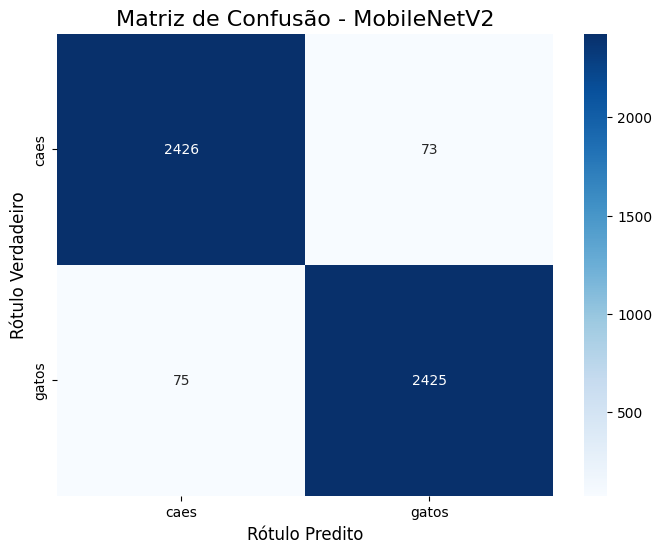

--------------------------------------------------
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step


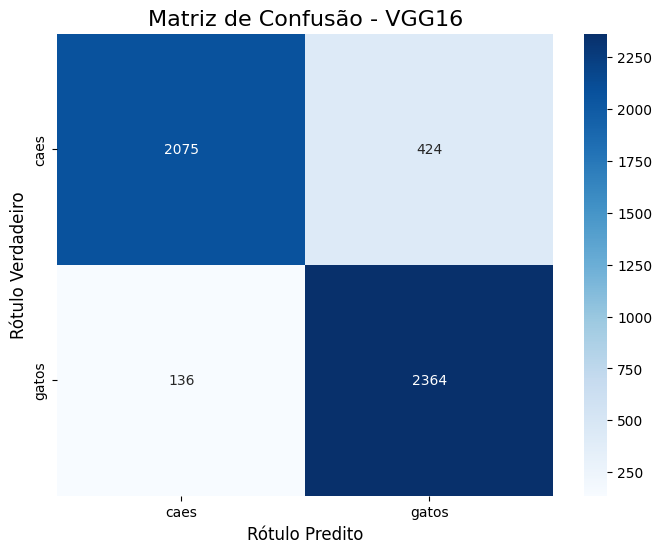

--------------------------------------------------


In [ ]:
modelo_top1 = model_mobilenetv2
modelo_top2 = model_cnn_vgg16

plotar_matriz_confusao(modelo_top1, "MobileNetV2" , validation_dataset, class_names)
plotar_matriz_confusao(modelo_top2, "VGG16", validation_dataset, class_names)

Observando a matriz podemos ver que a MobileNetV2 chegou a ter no máximo 75 falsos positivos e 75 falsos negativos, enquanto o VGG16 teve muito mais que esse número, sendo o principal erro os falsos positivos dos caes com 424, mais de 5 vezes maior do que o outro modelo

Comparando os dois melhores modelos

In [ ]:
def get_summary_as_html(model):
    """Captura o model.summary() e o formata como um bloco de texto HTML."""
    lines = []
    model.summary(print_fn=lambda x: lines.append(x))
    summary_html = "<pre>" + "<br>".join(lines) + "</pre>"
    return summary_html

html_summary_mobilenet = get_summary_as_html(base_model_mobilenet)
html_summary_vgg16 = get_summary_as_html(base_model_vgg16)

final_html = f"""
<h2 style="text-align: center;">Comparação de Topologias Base (Transfer Learning)</h2>
<div style="display: flex; flex-direction: row; justify-content: space-around; align-items: flex-start;">
    <div style="padding-right: 20px;">
        <h3 style="text-align: center;">MobileNetV2 (Base)</h3>
        {html_summary_mobilenet}
    </div>
    <div>
        <h3 style="text-align: center;">VGG16 (Base)</h3>
        {html_summary_vgg16}
    </div>
</div>
"""

display(HTML(final_html))

É perceptível a diferença no número de camadas entre esses dois modelos, o MobileNetV2 tem realmente bem mais camadas, contudo tem menos parâmetros, 2,257,984 vs 14,714,688 do VGG16, que por consequencia é mais pesado e é nisso que está o grande trunfo do MobileNetV2 tambem. Enquanto no VGG16 temos uma força bruta maior, no MobileNetV2 esta a busca da eficiência inteligente

Comparando agora a melhor rede CNN com a rede MLP

In [ ]:
acc_mlp = mlp_accuracy
params_mlp = mlp_params
mobilenetv2_accuracy = history_mobilenetv2.history['val_accuracy'][-1]
mobilenetv2_params = model_mobilenetv2.count_params()

acc_cnn = mobilenetv2_accuracy
params_cnn = mobilenetv2_params

print("--- Dados para Comparação ---")
print(f"MLP: Acurácia = {acc_mlp:.4f}, Parâmetros = {params_mlp:,}")
print(f"CNN (MobileNetV2): Acurácia = {acc_cnn:.4f}, Parâmetros = {params_cnn:,}")

--- Dados para Comparação ---
MLP: Acurácia = 0.6339, Parâmetros = 6,299,905
CNN (MobileNetV2): Acurácia = 0.9664, Parâmetros = 2,586,177


Comparando a rede MLP com a melhor CNN vemos uma grande diferença nos dois quesitos, bem menos parametros e acurácia bem menor tambem. Mesmo comparando com a CNN4(CNN sem tranfer learning mais robusta que tivemos), havia apenas 1,343,169 parametro, quase 3 vezes menos e novamente com uma grande difereça de acurácia(em torno de 20%). Todo esse contraste se deve principalmente a presença das camadas convolutivas nas CNNs, elas são as responsáveis por dar essa vantagem a elas, isso pois a tarefa estava relacionada com imagens, nelas as CNNs aprendem a ver padrões espaciais (bordas, texturas, formas), enquanto a MLP perde essa informação ao "achatar" a imagem, além disso,O mesmo filtro (com poucos parâmetros) é reutilizado em toda a imagem, enquanto a MLP precisa de um peso para cada pixel, o que gera uma explosão de parâmetros.